Imports

In [ ]:
#pip install --upgrade jaxlib
!pip install jaxlib==0.4.23
!pip install jax==0.4.23

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.2/77.2 MB 9.7 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.4.33 requires jaxlib<=0.4.33,>=0.4.33, but you have jaxlib 0.4.23 which is incompatible.
optax 0.2.3 requires jaxlib>=0.4.27, but you have jaxlib 0.4.23 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.1 MB/s eta 0:00:00
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.8.5 requ

In [ ]:
pip install --upgrade e3nn-jax

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 3.5 MB/s eta 0:00:00


In [ ]:
!pip install -q git+https://www.github.com/google/jax-md

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 185.6 kB/s eta 0:00:00


In [ ]:
pip install sympy

In [ ]:
pip install scikit-image

In [ ]:
import jax.numpy as np
import numpy as onp
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from jax.nn import relu
from jax import jit
from jax import vmap, pmap
from jax import lax
from jax import random
from jax import grad, value_and_grad, hessian, jacfwd, jacrev, jvp

from jax_md import space
from jax_md import quantity
from jax_md.quantity import box_size_at_number_density

#from jax.config import config
#config.update('jax_enable_x64', True)

from sympy import symbols
from sympy.plotting import plot
from sympy import diff, tanh

from scipy.sparse import csgraph

from functools import partial

import math
import matplotlib.pyplot as plt
#import numpy as np
import pandas as pd

from skimage.draw import ellipse
from skimage.measure import label, regionprops, regionprops_table
from skimage.transform import rotate

Predefined functions

In [ ]:
displacement, shift = space.free()
metric = space.metric(displacement)
displacement = space.map_product(displacement)
metric = space.map_product(metric)

Model parameters

In [ ]:
epsilon = 0.01
alpha =3.5

eta_1 = 1e-2
eta_2 = 1e-8

Initialization

Square Lattice

In [ ]:
def square_lattice(N, box_size):
  Nx = int(np.sqrt(N))
  Ny, ragged = divmod(N, Nx)
  if Ny != Nx or ragged:
    assert ValueError('Particle count should be a square. Found {}.'.format(N))
  length_scale = box_size / (Nx-1)
  R = []
  for i in range(Nx):
    for j in range(Ny):
      R.append([i * length_scale, j * length_scale])
  return np.array(R)

In [ ]:
rand_key=0

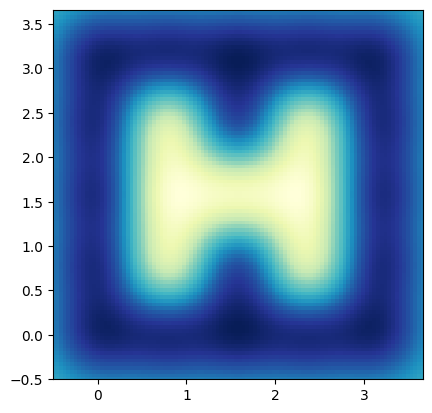

In [ ]:
N = 25
dim = 2

box_size = box_size_at_number_density(particle_count = N, number_density = N/10, spatial_dimension = dim)
R_target = square_lattice(N, box_size)
C_target = random.choice(random.PRNGKey(rand_key), np.array([-1, 1]), (R_target.shape[0],1))
C_target=C_target.at[1].set(1)
C_target=C_target.at[5].set(1)
C_target=C_target.at[7].set(-1)
C_target=C_target.at[10].set(1)
C_target=C_target.at[12].set(-1)
C_target=C_target.at[13].set(1)
C_target=C_target.at[14].set(1)
C_target=C_target.at[17].set(-1)
C_target=C_target.at[19].set(1)
C_target=C_target.at[21].set(1)
C_target=C_target.at[23].set(1)
C_target=C_target.at[24].set(1)














def phi_field(x):
    return np.einsum('i->', np.multiply(np.exp(np.squeeze(- alpha*np.square(metric(x, R_target)))), np.squeeze(C_target)))

batch_phi_field = vmap(phi_field)

n = 100

xmin = np.min(R_target[:,0]) - 0.5
xmax = np.max(R_target[:,0]) + 0.5
ymin = np.min(R_target[:,1]) - 0.5
ymax = np.max(R_target[:,1]) + 0.5

X, Y = np.mgrid[xmin:xmax:(n*1j), ymin:ymax:(n*1j)]
positions = np.transpose(np.vstack([X.ravel(), Y.ravel()]))
positions_list = np.reshape(positions, (n*n,1,2))

fig, ax = plt.subplots()

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')

ax.pcolormesh(X, Y, np.reshape(batch_phi_field(positions_list), (n,n)), cmap='YlGnBu')

plt.show()

Random cloud of droplets

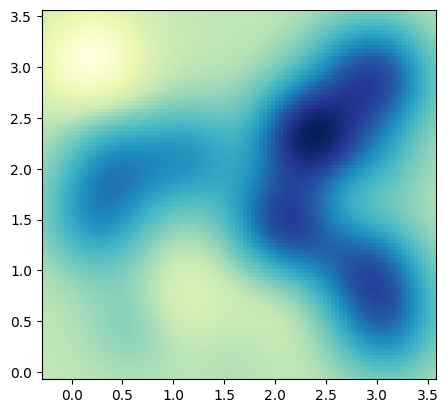

In [ ]:
N = 25
dim = 2

box_size = box_size_at_number_density(particle_count = N, number_density = N/10, spatial_dimension = dim)
R0 = random.uniform(random.PRNGKey(5), (N, dim), maxval=box_size)
C0 = random.choice(random.PRNGKey(rand_key), np.array([-1, 1]), (R0.shape[0],1))
C0=C0.at[1].set(1)
C0=C0.at[5].set(1)
C0=C0.at[7].set(-1)
C0=C0.at[10].set(1)
C0=C0.at[12].set(-1)
C0=C0.at[13].set(1)
C0=C0.at[14].set(1)
C0=C0.at[17].set(-1)
C0=C0.at[19].set(1)
C0=C0.at[21].set(1)
C0=C0.at[23].set(1)
C0=C0.at[24].set(1)

def phi_field(x):
    return np.einsum('i->', np.multiply(np.exp(np.squeeze(- alpha*np.square(metric(x, R0)))), np.squeeze(C0) ))

batch_phi_field = vmap(phi_field)

n = 100

xmin = np.min(R0[:,0]) - 0.5
xmax = np.max(R0[:,0]) + 0.5
ymin = np.min(R0[:,1]) - 0.5
ymax = np.max(R0[:,1]) + 0.5

X, Y = np.mgrid[xmin:xmax:(n*1j), ymin:ymax:(n*1j)]
positions = np.transpose(np.vstack([X.ravel(), Y.ravel()]))
positions_list = np.reshape(positions, (n*n,1,2))

fig, ax = plt.subplots()

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')

ax.pcolormesh(X, Y, np.reshape(batch_phi_field(positions_list), (n,n)), cmap='YlGnBu')

plt.show()

In [ ]:
C0-C_target

Array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int32)

Potential

Eulerian domain

In [ ]:
n = 100
xmin = np.min(R0[:,0]) - 0.5
xmax = np.max(R0[:,0]) + 0.5
ymin = np.min(R0[:,1]) - 0.5
ymax = np.max(R0[:,1]) + 0.5
X, Y = np.mgrid[xmin:xmax:(n*1j), ymin:ymax:(n*1j)]
positions = np.transpose(np.vstack([X.ravel(), Y.ravel()]))
positions_list = np.reshape(positions, (n*n,1,2))

In [ ]:
def landau(R):

  eta = 1e1
  beta = 10
  dx2 = ((xmax-xmin)/n)**2

  def phi_field(x):
    return np.einsum('i->', np.multiply(np.exp(np.squeeze(- alpha*np.square(metric(x, R)))), np.squeeze(C0) ))

  def grad_phi_field(x):
    return jacrev(phi_field, argnums=0)(x)

  batch_phi_field = vmap(phi_field)
  batch_grad_phi_field = vmap(grad_phi_field)

  return 0*0.001*dx2*np.einsum('i->', 5e2*np.square(1 - np.square(batch_phi_field(positions_list))) + np.einsum('ij->i', np.square(np.squeeze(batch_grad_phi_field(positions_list)))) )


In [ ]:
def boundedness(R):
  def phi_field(x):
    return np.einsum('i,i->', np.exp(np.squeeze(- alpha*np.square(metric(x, R)))), np.ones((R0.shape[0],1))[:,0])
  batch_phi_field = vmap(phi_field)
  phi_grid = np.reshape(batch_phi_field(positions_list), (n,n))
  return 1e0*np.einsum('ij->', np.square(relu(metric(np.array([[box_size/2, box_size/2]]), R) - box_size/8)))

#Uncontrolled

In [ ]:
R_iter = []
R_iter.append(R0)

t0 = 0.0
t1 = 0.5
dt = 0.001

D_R = 0.001

for i in range(int((t1-t0)/dt)):
  R_iter.append(R_iter[-1] - dt*jacrev(landau, argnums=0)(R_iter[-1]) + np.sqrt(2*D_R*dt)*random.normal(random.PRNGKey(int(time.time())), shape=R_iter[-1].shape))

KeyboardInterrupt: 

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter

fig_size = (10,10)
fig, ax = plt.subplots(figsize=fig_size)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')

def animate(j):
  k = 5*j
  ax.clear()

  R = R_iter[k]

  def phi_field(x):
    return np.einsum('i->', np.exp(np.squeeze(- alpha*np.square(metric(x, R)))))
  batch_phi_field = vmap(phi_field)

  phi_eval_euler = np.reshape(batch_phi_field(positions_list), (n,n))
  fgrnd1 = ax.pcolormesh(X, Y, phi_eval_euler,cmap='YlGnBu')

  return fgrnd1

ani = FuncAnimation(fig, animate, interval=50, blit=False, repeat=True, frames=int(len(R_iter)/5))
ani.save("CH_uncontrolled.gif", dpi=300, writer=PillowWriter(fps=10))

#Control

In [ ]:
#def terminal_cost(R):

  # dx2 = ((xmax-xmin)/n)**2

  #def phi_field(x):
   # return np.einsum('i->', np.multiply(np.exp(np.squeeze(- alpha*np.square(metric(x, R)))), np.squeeze(C0) ))

  #def phi_field_target(x):
   # return np.einsum('i->', np.multiply(np.exp(np.squeeze(- alpha*np.square(metric(x, R_target)))), np.squeeze(C_target) ))

  #batch_phi_field = vmap(phi_field)
  #batch_phi_field_target = vmap(phi_field_target)

  #phi_eval_euler = batch_phi_field(positions_list)
  #phi_eval_euler_target = batch_phi_field_target(positions_list)

  #  return 1e-1*np.einsum('i,i->' , phi_eval_euler-phi_eval_euler_target, phi_eval_euler-phi_eval_euler_target)+100000*np.einsum('ij->', np.square(relu(metric(np.array([[box_size/2, box_size/2]]), R) - box_size/2)))
  #return 1e-2*np.einsum('i,i->' , phi_eval_euler-phi_eval_euler_target, phi_eval_euler-phi_eval_euler_target)

 # return np.einsum('ij,ij->', R-R_target, R-R_target)

In [ ]:
def terminal_cost(R):

  # dx2 = ((xmax-xmin)/n)**2

  def phi_field(x):
    return np.einsum('i->', np.multiply(np.exp(np.squeeze(- alpha*np.square(metric(x, R)))), np.squeeze(C0) ))

  def phi_field_target(x):
    return np.einsum('i->', np.multiply(np.exp(np.squeeze(- alpha*np.square(metric(x, R_target)))), np.squeeze(C_target) ))

  batch_phi_field = vmap(phi_field)
  batch_phi_field_target = vmap(phi_field_target)

  phi_eval_euler = batch_phi_field(positions_list)
  phi_eval_euler_target = batch_phi_field_target(positions_list)

  #  return 1e-1*np.einsum('i,i->' , phi_eval_euler-phi_eval_euler_target, phi_eval_euler-phi_eval_euler_target)+100000*np.einsum('ij->', np.square(relu(metric(np.array([[box_size/2, box_size/2]]), R) - box_size/2)))
  return 1e-2*np.einsum('i,i->' , phi_eval_euler-phi_eval_euler_target, phi_eval_euler-phi_eval_euler_target)

  #return np.einsum('ij,ij->', R-R_target, R-R_target)

In [ ]:
D_R = 0.00000001

t0, t1 = 0, 0.01
dt = 0.01

n_samples = 1

In [ ]:
def ctrl(R):

  R_iter_ctrl = []
  R_iter_ctrl.append(R)

  for k in range(int((t1-t0)/dt)):
    R_iter_ctrl.append(R_iter_ctrl[-1] - dt*jacrev(landau, argnums=0)(R_iter_ctrl[-1]) + np.sqrt(2*D_R*dt)*random.normal(random.PRNGKey(int(time.time())), shape=R_iter_ctrl[-1].shape))

  Lambda_R_iter = []
  Lambda_R_iter.append(jacrev(terminal_cost, argnums=0)(R_iter_ctrl[-1]))

  for t in range(int((t1-t0)/dt)):
    ind = int(t1/dt)-t
    Lambda_R_iter.append(Lambda_R_iter[-1] + dt*(np.einsum('ij,ijkl->kl', Lambda_R_iter[-1], -jacfwd(jacrev(landau, argnums=0), argnums=0)(R_iter_ctrl[ind]))))

  return -Lambda_R_iter[-1]

In [ ]:
R_iter = []
R_iter.append(R0)
cost=[]
r_control=[]

In [ ]:
t = 0.0

while(np.sqrt(terminal_cost(R_iter[-1])) > 1e-2):

  print(t, np.sqrt(terminal_cost(R_iter[-1])))
  cost.append(np.sqrt(terminal_cost(R_iter[-1])))
  t = t + dt

  u_R = ctrl(R_iter[-1])

  r_control.append(u_R)


  R_iter.append(R_iter[-1] - dt*jacrev(landau, argnums=0)(R_iter[-1]) + dt*u_R + np.sqrt(2*D_R*dt)*random.normal(random.PRNGKey(int(time.time())), shape=R_iter[-1].shape))

0.0 12.660231
0.01 8.735974
0.02 6.952897
0.03 5.7284307
0.04 4.946744
0.05 4.428073
0.060000000000000005 4.064062
0.07 3.788337
0.08 3.564836
0.09 3.374738
0.09999999999999999 3.2087877
0.10999999999999999 3.0630991
0.11999999999999998 2.9357429
0.12999999999999998 2.8248034
0.13999999999999999 2.7278528
0.15 2.6422253
0.16 2.565595
0.17 2.4959366
0.18000000000000002 2.4317212
0.19000000000000003 2.371928
0.20000000000000004 2.3157697
0.21000000000000005 2.262796
0.22000000000000006 2.21273
0.23000000000000007 2.1653895
0.24000000000000007 2.1206183
0.25000000000000006 2.0781972
0.26000000000000006 2.0380058
0.2700000000000001 1.999808
0.2800000000000001 1.9634538
0.2900000000000001 1.9286973
0.3000000000000001 1.8953693
0.3100000000000001 1.8634107
0.3200000000000001 1.8325968
0.3300000000000001 1.8029546
0.34000000000000014 1.7743675
0.35000000000000014 1.7468405
0.36000000000000015 1.7202928
0.37000000000000016 1.6947342
0.38000000000000017 1.6701347
0.3900000000000002 1.6465353
0.

KeyboardInterrupt: 

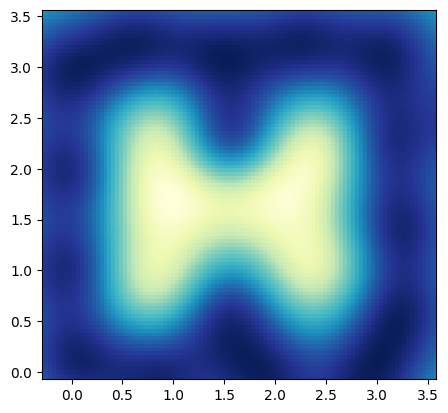

In [ ]:
R = R_iter[-1]

n = 100

xmin = np.min(R0[:,0]) - 0.5
xmax = np.max(R0[:,0]) + 0.5
ymin = np.min(R0[:,1]) - 0.5
ymax = np.max(R0[:,1]) + 0.5

X, Y = np.mgrid[xmin:xmax:(n*1j), ymin:ymax:(n*1j)]
positions = np.transpose(np.vstack([X.ravel(), Y.ravel()]))
positions_list = np.reshape(positions, (n*n,1,2))

def phi_field(x):
    return np.einsum('i->', np.multiply(np.exp(np.squeeze(- alpha*np.square(metric(x, R)))), np.squeeze(C0)))

batch_phi_field = vmap(phi_field)

fig, ax = plt.subplots()

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
ax.pcolormesh(X, Y, np.reshape(batch_phi_field(positions_list), (n,n)),cmap='YlGnBu')

plt.show()

In [ ]:
len(R_iter)

112

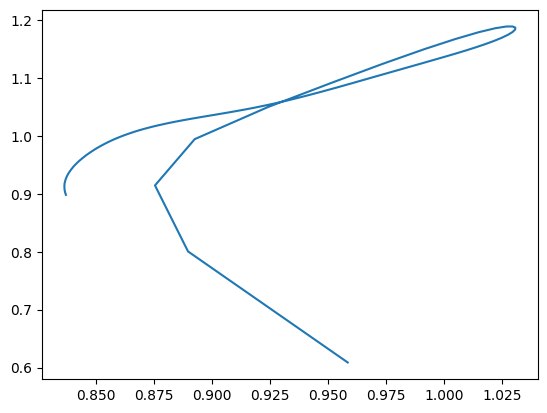

In [ ]:
x_traj=np.array(R_iter)[:,6,0]
y_traj=np.array(R_iter)[:,6,1]
plt.plot(x_traj,y_traj)

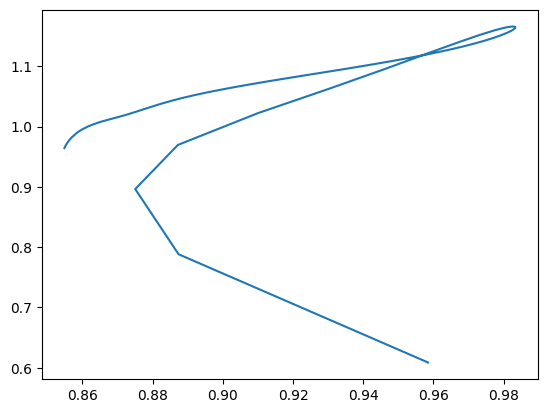

In [ ]:
x_traj=np.array(R_iter)[:,6,0]
y_traj=np.array(R_iter)[:,6,1]
plt.plot(x_traj,y_traj)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/generative_pattern_formation/cahn_hilliard/

/content/drive/MyDrive/generative_pattern_formation/cahn_hilliard


In [ ]:
ls

 ch_controlled.gif       ch_controlled_new_new.gif     ch_quiver.gif   free_energy.pdf
 ch_controlled_new.gif   ch_controlled_new_new_H.gif   error.pdf      'Squared Control Cost.pdf'


In [ ]:
np.save('R_iter_25_particles_new', R_iter, allow_pickle=True)

In [ ]:
np.save('cost_25_particles_new', cost, allow_pickle=True)

In [ ]:
np.save('free_energy_25_particles_new', free_energy, allow_pickle=True)

In [ ]:
np.save('control_cost_25_particles_new', control_cost, allow_pickle=True)

In [ ]:
np.save('r_control_25_particles_new', r_control, allow_pickle=True)

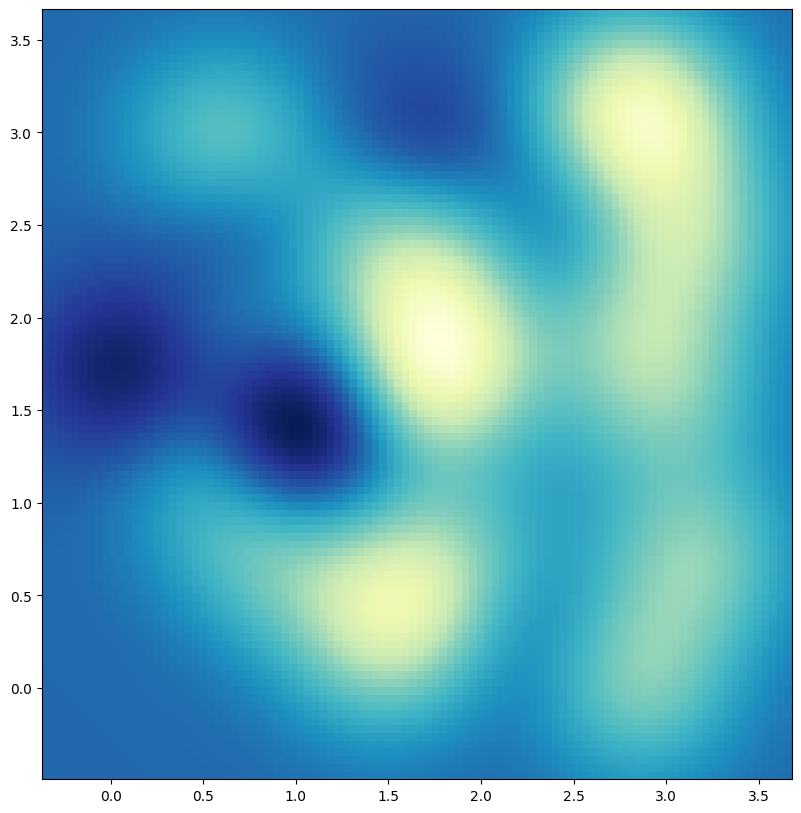

In [ ]:
no_of_frames=len(R_iter)
from matplotlib.animation import FuncAnimation, PillowWriter

fig_size = (10,10)
fig, ax = plt.subplots(figsize=fig_size)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')

def animate(j):
  #print(j)
  k = int(len(R_iter)/no_of_frames)*j
  #k=j
  ax.clear()

  R = R_iter[k]

  def phi_field(x):
    return np.einsum('i->', np.multiply(np.exp(np.squeeze(- alpha*np.square(metric(x, R)))), np.squeeze(C0)))
  batch_phi_field = vmap(phi_field)

  phi_eval_euler = np.reshape(batch_phi_field(positions_list), (n,n))
  fgrnd1 = ax.pcolormesh(X, Y, phi_eval_euler,cmap='YlGnBu')

  return fgrnd1

ani = FuncAnimation(fig, animate, interval=50, blit=False, repeat=True, frames=no_of_frames)
ani.save("ch_controlled_new_new_H.gif", dpi=300, writer=PillowWriter(fps=10))

In [ ]:
pwd

'/content/drive/MyDrive/generative_pattern_formation/cahn_hilliard'

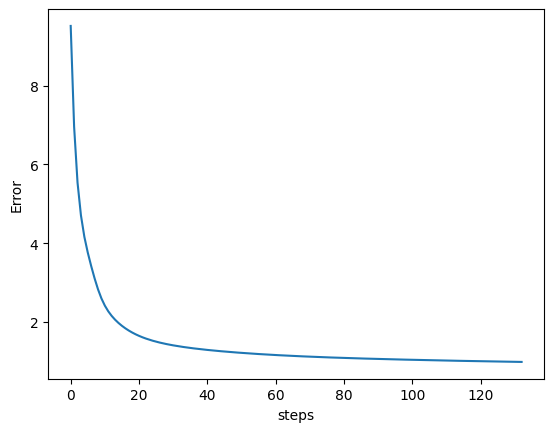

In [ ]:
plt.plot(cost)
plt.xlabel('steps')
plt.ylabel('Error')
plt.savefig('error.pdf',bbox_inches='tight')

In [ ]:
free_energy=[]
for i in range(len(R_iter)):
  free_energy.append(landau(R_iter[i]))

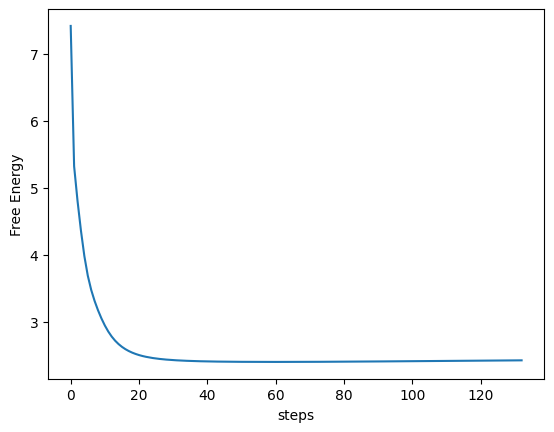

In [ ]:
plt.plot(free_energy)
plt.xlabel('steps')
plt.ylabel('Free Energy')
plt.savefig('free_energy.pdf',bbox_inches='tight')

In [ ]:
control_cost=[]
for i in range(len(r_control)):
  control_cost.append(np.sum(np.square(r_control[i])))

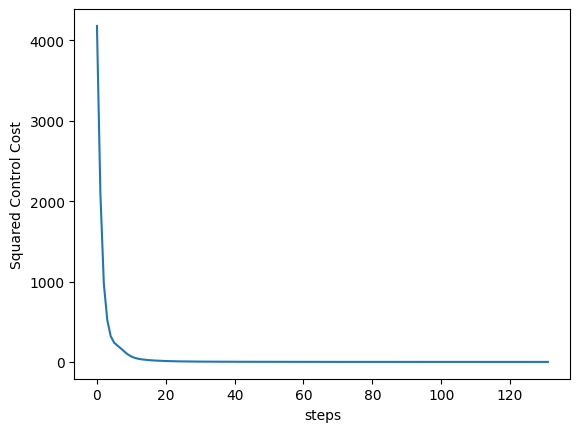

In [ ]:
plt.plot(control_cost)
plt.xlabel('steps')
plt.ylabel('Squared Control Cost')
plt.savefig('Squared Control Cost.pdf',bbox_inches='tight')

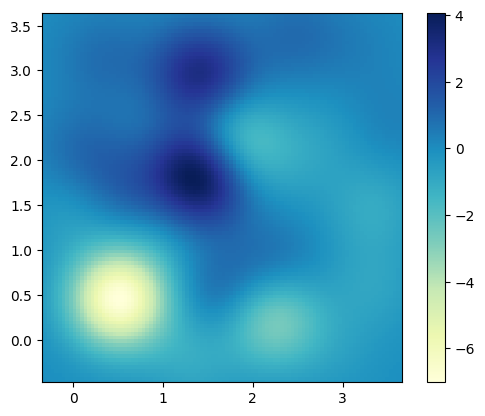

In [ ]:
R_control = r_control[6]
R=R_iter[6]

n = 100

xmin = np.min(R0[:,0]) - 0.5
xmax = np.max(R0[:,0]) + 0.5
ymin = np.min(R0[:,1]) - 0.5
ymax = np.max(R0[:,1]) + 0.5

X, Y = np.mgrid[xmin:xmax:(n*1j), ymin:ymax:(n*1j)]
positions = np.transpose(np.vstack([X.ravel(), Y.ravel()]))
positions_list = np.reshape(positions, (n*n,1,2))

def velocity_control_field_x(x):
    return np.einsum('i->', np.multiply(np.exp(np.squeeze(- alpha*np.square(metric(x, R)))), R_control[:,0]))

def velocity_control_field_y(x):
    return np.einsum('i->', np.multiply(np.exp(np.squeeze(- alpha*np.square(metric(x, R)))), R_control[:,1]))
batch_velocity_control_field_x = vmap(velocity_control_field_x)
batch_velocity_control_field_y = vmap(velocity_control_field_y)

fig, ax = plt.subplots()

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
im = ax.pcolormesh(X, Y, np.reshape(batch_velocity_control_field_y(positions_list), (n,n)),cmap='YlGnBu')
fig.colorbar(im, ax=ax)

plt.show()

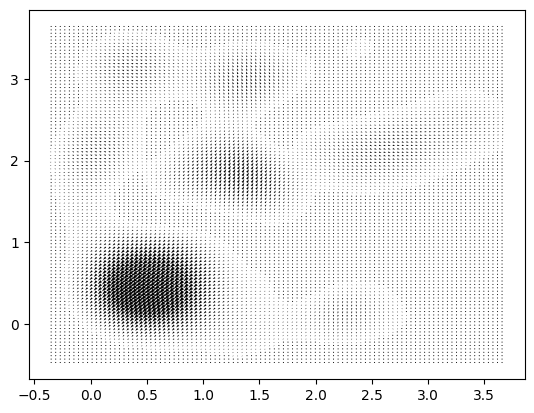

In [ ]:
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure()

ax = fig.add_subplot(111)
#div = make_axes_locatable(ax)
#cax = div.append_axes('right', '5%', '5%')
im=ax.quiver(X, Y,np.reshape(batch_velocity_control_field_x(positions_list), (n,n)),np.reshape(batch_velocity_control_field_y(positions_list), (n,n)), scale=600)
#fig.colorbar(im, cax=cax)

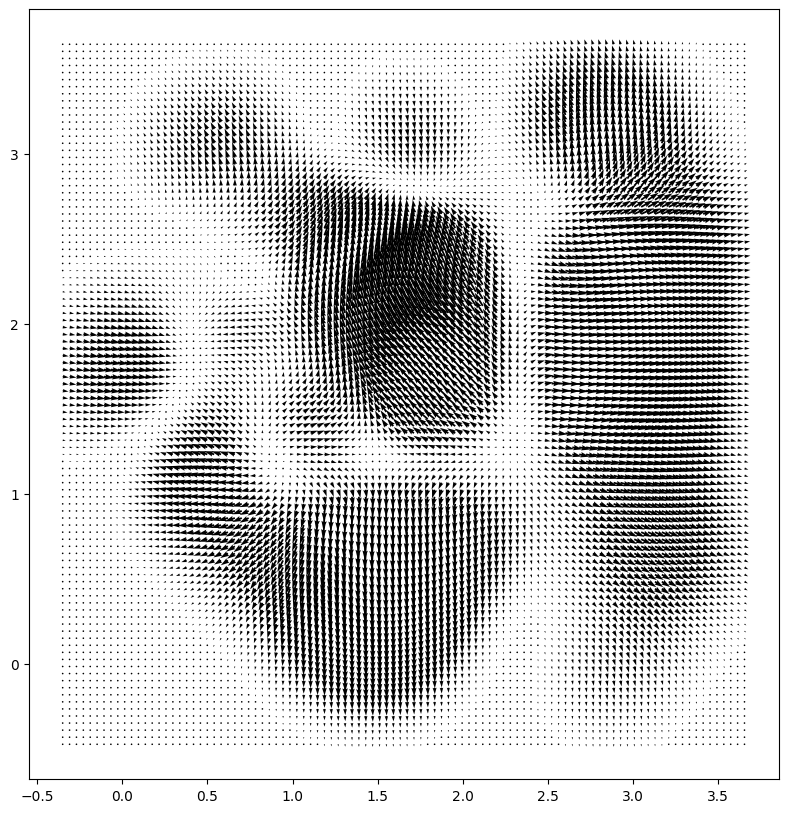

In [ ]:
no_of_frames=len(r_control)
from matplotlib.animation import FuncAnimation, PillowWriter

fig_size = (10,10)
fig, ax = plt.subplots(figsize=fig_size)

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')

def animate(j):
  #print(j)
  #k = int(len(C_iter)/no_of_frames)*j
  #k=j
  ax.clear()

  R = R_iter[j]
  R_control = r_control[j]



  def velocity_control_field_x(x):
    return np.einsum('i->', np.multiply(np.exp(np.squeeze(- alpha*np.square(metric(x, R)))), R_control[:,0]))

  def velocity_control_field_y(x):
    return np.einsum('i->', np.multiply(np.exp(np.squeeze(- alpha*np.square(metric(x, R)))), R_control[:,1]))
  batch_velocity_control_field_x = vmap(velocity_control_field_x)
  batch_velocity_control_field_y = vmap(velocity_control_field_y)

  im=ax.quiver(X, Y,np.reshape(batch_velocity_control_field_x(positions_list), (n,n)),np.reshape(batch_velocity_control_field_y(positions_list), (n,n)), scale=600)
#fig.colorbar(im, cax=cax)

  return im

ani = FuncAnimation(fig, animate, interval=50, blit=False, repeat=True, frames=no_of_frames)
ani.save("ch_quiver.gif", dpi=300, writer=PillowWriter(fps=5))

##Curvature Analysis

In [ ]:
ls

In [ ]:
import os
os.getcwd()

'/Users/vishaalkrishnan'

In [ ]:
R_iter = np.load('Desktop/figures_ST/data/R_iter_25_particles_new.npy', allow_pickle=True)

In [ ]:
R_iter=np.load('R_iter_25_particles_new.npy', allow_pickle=True)

FileNotFoundError: [Errno 2] No such file or directory: 'R_iter_25_particles_new.npy'

In [ ]:
time=np.linspace(0,1,len(R_iter))

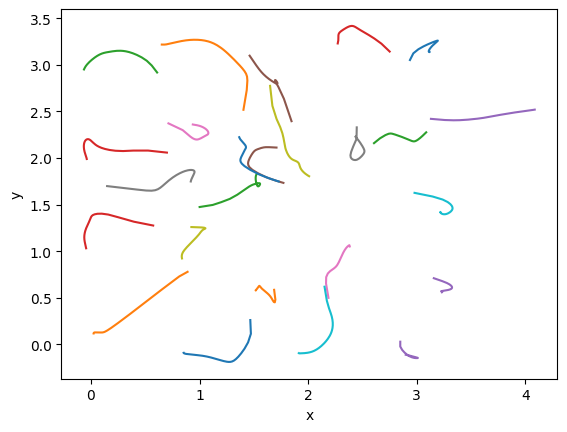

In [ ]:
plt.plot(R_iter[:,:,0],R_iter[:,:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('trajectory.pdf',bbox_inches='tight')

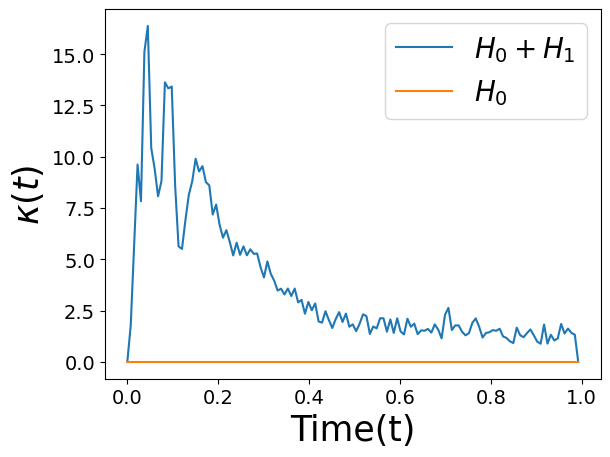

In [ ]:
import jax.numpy as jnp
from jax import vmap
import jax.lax as lax
import matplotlib.pyplot as plt

# Example R_iter array
T = 133
no_of_particles = 25
dim = 2
#R_iter = jnp.random.rand(T, no_of_particles, dim)  # Random example data

# Define a function to calculate curvature for a single particle
def curvature(t, particle_data):
    dt = 1.0  # assuming uniform time steps

    # First derivatives (velocity)
    def compute_first_derivative(particle_data, t, dt):
        return (particle_data[t+1] - particle_data[t-1]) / (2 * dt)

    first_derivative = lax.cond(
        (t > 0) & (t < T - 1),
        lambda _: compute_first_derivative(particle_data, t, dt),
        lambda _: jnp.zeros(2),
        None
    )

    # Second derivatives (acceleration)
    def compute_second_derivative(particle_data, t, dt):
        return (particle_data[t+1] - 2 * particle_data[t] + particle_data[t-1]) / (dt ** 2)

    second_derivative = lax.cond(
        (t > 0) & (t < T - 1),
        lambda _: compute_second_derivative(particle_data, t, dt),
        lambda _: jnp.zeros(2),
        None
    )

    # Calculate curvature
    def curvature_formula(first_derivative, second_derivative):
        num = jnp.abs(first_derivative[0] * second_derivative[1] - first_derivative[1] * second_derivative[0])
        denom = (first_derivative[0]**2 + first_derivative[1]**2)**(3/2)
        return num / (denom + 1e-8)

    curvature_val = lax.cond(
        (t > 0) & (t < T - 1),
        lambda _: curvature_formula(first_derivative, second_derivative),
        lambda _: 0.0,
        None
    )

    return curvature_val

# Vectorize the curvature calculation for all time steps
curvature_vmap = vmap(curvature, in_axes=(0, None))

# For each particle, calculate the curvature over time
curvature_over_time = jnp.array([curvature_vmap(jnp.arange(T), R_iter[:, particle_idx, :]) for particle_idx in range(no_of_particles)])

# Calculate the mean curvature across all particles for each time step
mean_curvature_over_time = jnp.mean(curvature_over_time, axis=0)

# Plot mean curvature as a function of time
plt.plot(jnp.arange(T)/T, mean_curvature_over_time, label='$H_0+H_1$')
plt.plot(jnp.arange(T)/T, jnp.zeros(mean_curvature_over_time.shape),label='$H_0$')
plt.xlabel('Time(t)', fontsize=25)
plt.ylabel('$\kappa(t)$',fontsize=25)
#plt.title('Mean Curvature Over Time')
plt.legend(loc='best',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('curvature_CH.pdf',bbox_inches='tight')
plt.show()

In [ ]:
cd ..

/content


In [ ]:
ls

drive/  sample_data/
